In [1]:
#importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

In [2]:
#load dataset
df = pd.read_csv('BTC.csv', parse_dates=['Date'])

In [3]:
df = df.sort_values('Date')

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-17,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-18,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-19,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-20,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [5]:
df.shape

(3201, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201 entries, 0 to 3200
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3201 non-null   datetime64[ns]
 1   Open       3201 non-null   float64       
 2   High       3201 non-null   float64       
 3   Low        3201 non-null   float64       
 4   Close      3201 non-null   float64       
 5   Adj Close  3201 non-null   float64       
 6   Volume     3201 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 200.1 KB


Text(0, 0.5, 'Close Price (USD)')

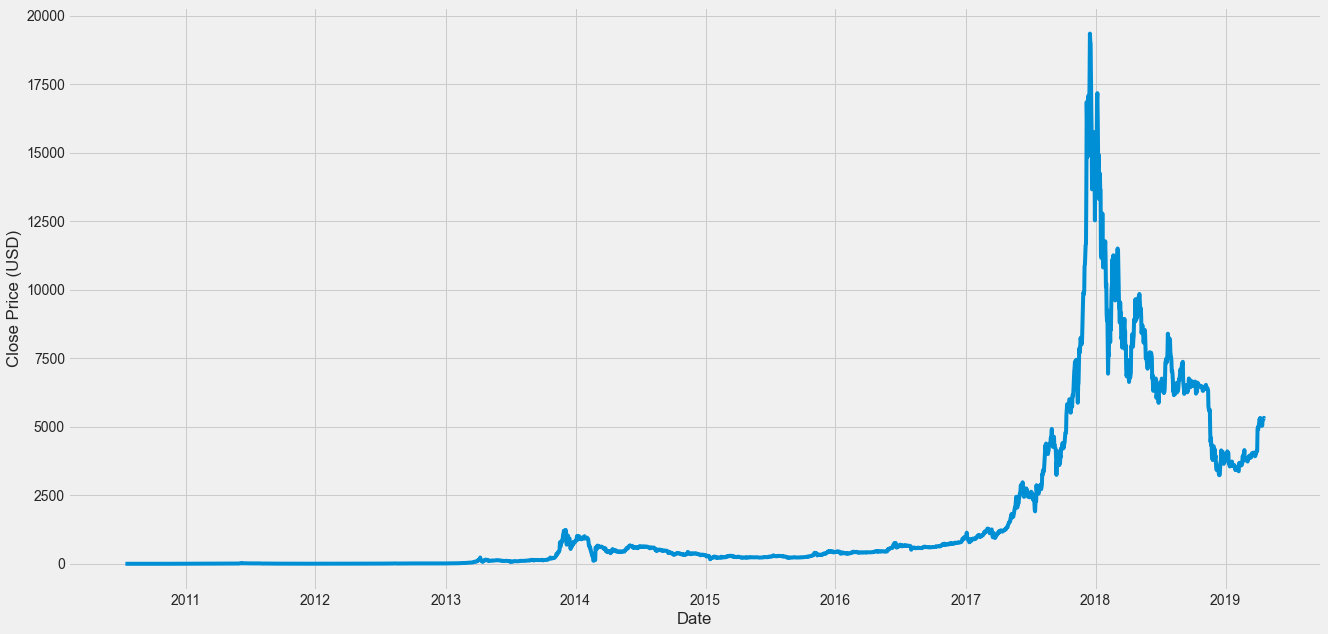

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df['Date'], df['Close'])
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [9]:
price = df[['Close']]

In [10]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

norm_data = min_max_scaler.fit_transform(price.values)

In [11]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

past_history = 5
future_target = 0

TRAIN_SPLIT = int(len(norm_data) * 0.8)


x_train, y_train = univariate_data(norm_data,
                                   0,
                                   TRAIN_SPLIT,
                                   past_history,
                                   future_target)

x_test, y_test = univariate_data(norm_data,
                                 TRAIN_SPLIT,
                                 None,
                                 past_history,
                                 future_target)

In [22]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, LSTM, LeakyReLU, Dropout

num_units = 64
learning_rate = 0.0001
activation_function = 'linear'
adam = Adam(lr=learning_rate)
loss_function = 'mse'
batch_size = 65
num_epochs = 50

# Initialize the RNN
model = Sequential()
model.add(LSTM(units = num_units, activation=activation_function, input_shape=(None, 1)))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer=adam, loss=loss_function)

In [23]:
# Using the training set to train the model
history = model.fit(
    x_train,
    y_train,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=num_epochs,
    shuffle=False
)

Epoch 1/50
36/36 [==============================] - 1s 20ms/step - loss: 1.9497e-04 - val_loss: 0.0045
Epoch 2/50
36/36 [==============================] - 0s 7ms/step - loss: 1.6056e-04 - val_loss: 0.0040
Epoch 3/50
36/36 [==============================] - 0s 7ms/step - loss: 1.5994e-04 - val_loss: 0.0037
Epoch 4/50
36/36 [==============================] - 0s 7ms/step - loss: 1.4718e-04 - val_loss: 0.0035
Epoch 5/50
36/36 [==============================] - 0s 7ms/step - loss: 1.4000e-04 - val_loss: 0.0033
Epoch 6/50
36/36 [==============================] - 0s 7ms/step - loss: 1.3464e-04 - val_loss: 0.0032
Epoch 7/50
36/36 [==============================] - 0s 7ms/step - loss: 1.2884e-04 - val_loss: 0.0030
Epoch 8/50
36/36 [==============================] - 0s 7ms/step - loss: 1.2156e-04 - val_loss: 0.0028
Epoch 9/50
36/36 [==============================] - 0s 7ms/step - loss: 1.1613e-04 - val_loss: 0.0026
Epoch 10/50
36/36 [==============================] - 0s 7ms/step - loss: 1.0917e-

[]

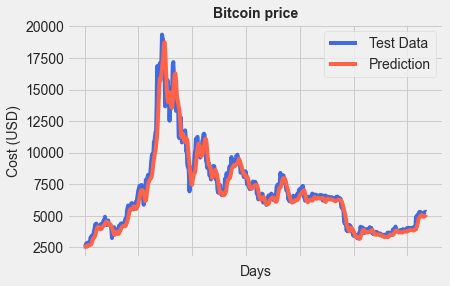

In [24]:
original = pd.DataFrame(min_max_scaler.inverse_transform(y_test))
predictions = pd.DataFrame(min_max_scaler.inverse_transform(model.predict(x_test)))

ax = sns.lineplot(x=original.index, y=original[0], label="Test Data", color='royalblue')
ax = sns.lineplot(x=predictions.index, y=predictions[0], label="Prediction", color='tomato')
ax.set_title('Bitcoin price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)